# import package

The dataset used in this notebook is Tesla stock history from 2014 to 2017. You can find the .csv file in the project folder.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Step 0. Loading dataset

In [2]:
tesla_stocks = pd.read_csv('data/tesla_stocks.csv')

In [3]:
#資料共有六個資訊，日期、開盤、當日最高、當日最低、收盤、成交量
tesla_stocks.head()

Date    Open    High     Low   Close   Volume
0  4-Aug-14  234.38  240.50  233.27  238.52  5967406
1  5-Aug-14  237.47  242.99  235.69  238.49  5388581
2  6-Aug-14  238.90  251.42  238.58  248.93  9249265
3  7-Aug-14  250.12  256.69  249.12  252.39  7478926
4  8-Aug-14  251.16  251.76  246.50  248.13  5099061

In [4]:
#簡化預測複雜度，我們只使用收盤價預測
data_to_use = tesla_stocks['Close'].values

In [5]:
#資料共有756天成交紀錄
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


### Step 1. Data preprocessing

#### Step 1.1 Scaling data

In [6]:
#使用sklearn套件將資料標準化(mean = 0, std = 1)
scaler = StandardScaler()

In [7]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

In [8]:
print("std: ", scaled_dataset.std())
print("mean: ", scaled_dataset.mean())

std:  0.9999999999999999
mean:  4.69935671799008e-16


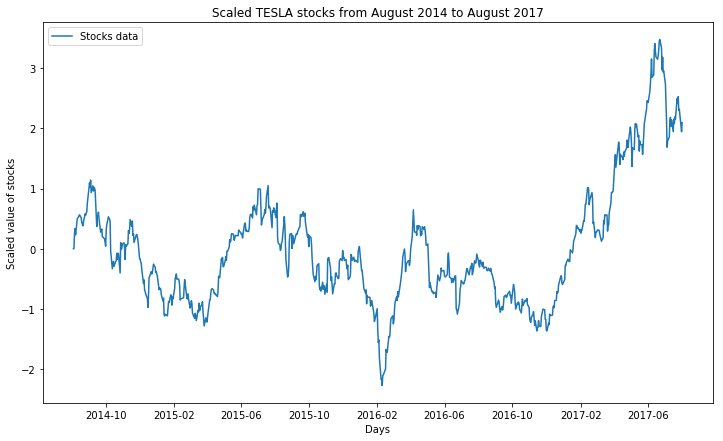

In [9]:
tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(tesla_stocks.Date, scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

#### 透過下面左右圖的縱軸的數值，可以觀察到Scale前後的差異，但是在整體的pattern圖像還是保持相同。

<Figure size 432x288 with 0 Axes>

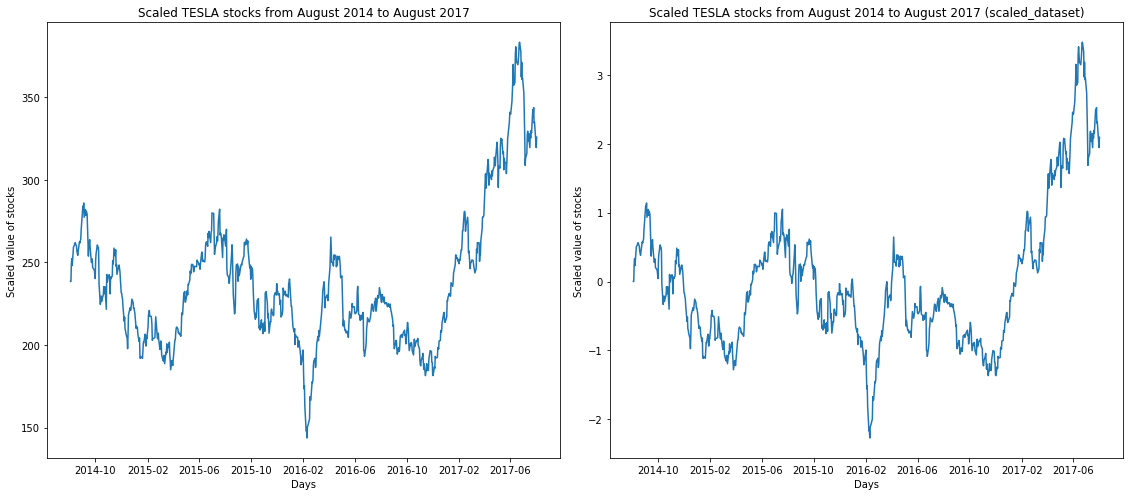

In [80]:

box = [data_to_use,scaled_dataset]

fig = plt.figure()

fig = plt.figure(figsize=(16,7), frameon=False, facecolor='brown', edgecolor='blue')


ax1 = fig.add_subplot(121)
ax1.plot(tesla_stocks.Date, box[0], label='Stocks data')
ax1.set_title('Scaled TESLA stocks from August 2014 to August 2017')
ax1.set_ylabel('Scaled value of stocks')
ax1.set_xlabel('Days')



ax2 = fig.add_subplot(122)
ax2.set_title('Scaled TESLA stocks from August 2014 to August 2017 (scaled_dataset)')
ax2.set_ylabel('Scaled value of stocks')
ax2.set_xlabel('Days')
ax2.plot(tesla_stocks.Date, box[1], label='Stocks data')


fig.tight_layout()

#plotly_fig = tls.mpl_to_plotly( fig )
#plotly_url = py.plot(plotly_fig)

# Config 

In [81]:
#參數設定
learning_rate=0.001
batch_size=8
epochs = 200
rnn_size=512
number_of_layers=1
number_of_classes=1
window_size=20

In [82]:
#抓取window_size的資料作為觀察資料(x), 下一天作為預測資料(y)
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#### Step 1.2 Windowing the dataset

In [83]:
X, y = window_data(scaled_dataset, window_size)

#### Step 1.3 Creating Training and Testing sets

In [84]:
#將前700筆作為訓練資料，700~749作為測試資料
X_train  = np.array(X[:700])
y_train = np.array(y[:700])

X_test = np.array(X[700:])
y_test = np.array(y[700:])

#X shape (700, 7, 1) 700筆資料, 每一筆資料有七個close price
#y shape (700, 1) 700筆資料, 每一筆資料有一個close price
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 20, 1)
y_train size: (700, 1)
X_test size: (36, 20, 1)
y_test size: (36, 1)


### Let's create the RNN

In [85]:
#rnn_size 是LSTM內neuron的數量
#若想堆疊堆多層LSTM使用tf.contrib.rnn.MultiRNNCell
#LSTM起始時init_state內沒有資料，先給初始值0

def get_RNN(rnn_size, keep_prob):
    BasicRNN_layer = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    RNN_layer = tf.contrib.rnn.DropoutWrapper(BasicRNN_layer, output_keep_prob=keep_prob)
    return RNN_layer

def LSTM_cell(rnn_size, X, number_of_layers, keep_prob):    
    cell = tf.contrib.rnn.MultiRNNCell([get_RNN(rnn_size, keep_prob) for _ in range(number_of_layers)])
    init_state = cell.zero_state(tf.shape(X)[0], tf.float32)
    return cell, init_state

In [86]:
# outputs_shape (batch_size, timesteps, LSTM_units)
# 將lstm_output最後的輸出值再經過一層hidden layer後輸出
# 取最後一個時間點LSTM的輸出值[:, -1, :]

def output_layer(lstm_output, out_size):
    x = lstm_output[:, -1, :]
    output = tf.layers.dense(inputs= x, units= out_size)
    return output

In [87]:
# RNN及LSTM會有梯度爆炸的問題，因此若斜率超過+-5則clip到+-5之內
def opt_loss(logits, targets, learning_rate):
    
    loss = tf.reduce_mean(tf.pow(logits - targets, 2))
    
    #Cliping the gradient loss
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = optimizer.compute_gradients(loss)

    capped_gradients = [(tf.clip_by_value(grad, -5, 5), var) for grad, var in gradients if grad is not None]
    
    train_optimizer = optimizer.apply_gradients(capped_gradients)

    
    return loss, train_optimizer

### Tensorflow- 建立靜態圖 

**靜態圖**就像一張計畫圖一樣，定義我們的計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行

In [88]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    ##defining placeholders##
    with tf.name_scope('input'):
        inputs = tf.placeholder(tf.float32, [None, window_size, 1], name='input_data')
        targets = tf.placeholder(tf.float32, [None, 1], name='targets')
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        
    ##LSTM layer##
    with tf.variable_scope("LSTM_layer"):
        cell, init_state = LSTM_cell(rnn_size, inputs, number_of_layers, keep_prob) 
        outputs, states = tf.nn.dynamic_rnn(cell, inputs, initial_state=init_state)
    
    ##Output layer##   
    with tf.variable_scope('output_layer'):
        logits = output_layer(outputs, number_of_classes)
    
    ##loss and optimization##
    with tf.name_scope('loss_and_opt'):
        loss, opt = opt_loss(logits, targets, learning_rate)
    
    init = tf.global_variables_initializer()
    

### Tensorflow- 初始化模型

In [89]:
#### initialize model ####
sess.run(init)

### Tensorflow- 實際執行模型訓練

In [90]:
for i in range(epochs):
    batch_index = 0
    epoch_loss = []
    while(batch_index + batch_size) <= len(X_train):
        X_batch = X_train[batch_index:batch_index+batch_size]
        y_batch = y_train[batch_index:batch_index+batch_size]
        batch_loss, _ = sess.run([loss, opt], feed_dict={inputs:X_batch, targets:y_batch, keep_prob: 0.8})
        epoch_loss.append(batch_loss)
        batch_index += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.135207399725914
Epoch 30/200  Current loss: 0.02128336951136589
Epoch 60/200  Current loss: 0.021657491102814674
Epoch 90/200  Current loss: 0.02175666019320488
Epoch 120/200  Current loss: 0.020816069096326828
Epoch 150/200  Current loss: 0.020799797028303146
Epoch 180/200  Current loss: 0.019417714327573776


In [26]:
#Training set預測結果
training_set_pred = np.array([])
for i in range(len(X_train)):
    o = sess.run(logits, feed_dict={inputs:[X_train[i]], keep_prob: 1.0})
    training_set_pred = np.append(training_set_pred, o)

In [27]:
#Testing set預測結果
testing_set_pred = np.array([])
for i in range(len(X_test)):
    o = sess.run(logits, feed_dict={inputs:[X_test[i]], keep_prob: 1.0})
    testing_set_pred = np.append(testing_set_pred, o)    

In [28]:
#把資料放到list裡面準備畫圖
#因為我們是用前七天預測第8天股價，故前七天設為None
training = [None]*window_size
for i in range(len(X_train)):
    training.append(training_set_pred[i])
testing = [None] * (window_size + len(X_train))
testing_loss = 0
for i in range(len(X_test)):
    testing.append(testing_set_pred[i])
    testing_loss += (testing_set_pred[i] - y_test[i])**2
    training.append(None)
print('testing loss:', testing_loss / len(X_test))

testing loss: [0.05200792]


### Plotting predictions from the network

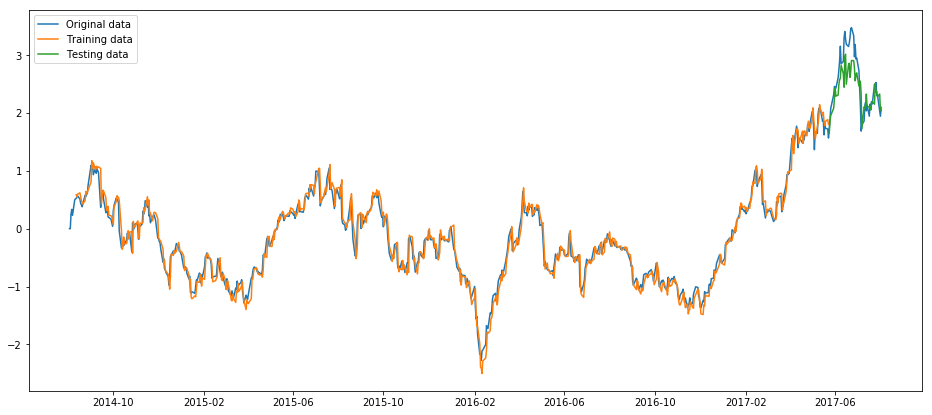

In [37]:
plt.figure(figsize=(16, 7))
plt.plot(tesla_stocks.Date, scaled_dataset, label='Original data')
plt.plot(tesla_stocks.Date, training, label='Training data')
plt.plot(tesla_stocks.Date, testing, label='Testing data')
plt.legend()
plt.show()

In [24]:
sess.close()

## 練習
1. 把Open、High、Low、Close跟Volume都當Feature